In [2]:
from numpy import append, arange, argsort, array, average, corrcoef, cumsum, diff, exp, eye, interp, insert, log, \
                  max, min, ones, round, searchsorted, sort, spacing, squeeze, sum, where, zeros, zeros_like
from scipy.stats import multivariate_t, t
from bisect import bisect_right
from pandas import DatetimeIndex, read_csv, Series
from seaborn import histplot, scatterplot
from matplotlib.pyplot import show
from arpym.views.min_rel_entropy_sp import min_rel_entropy_sp

db_stocks_sp = read_csv('~/Databases/global-databases/equities/db_stocks_SP500/db_stocks_sp.csv',
                        skiprows=[0], index_col=0, parse_dates=True)

###################### input #######################
stocks = ['A', 'AA']  # asset scelti
########################################################################

db_vix_data = read_csv('~/Databases/global-databases/derivatives/db_vix/data.csv', 
                       usecols=['date', 'VIX_close'], index_col=0, parse_dates=True)
dates = DatetimeIndex.intersection(db_stocks_sp.index, db_vix_data.index)  # match delle date
v = array(db_stocks_sp.loc[dates, stocks].values).T  # value degli asset scelti


e_z= [1.78387036e-14 2.78788494e-13]


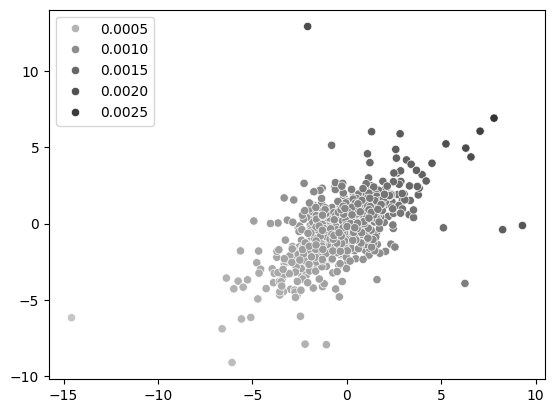

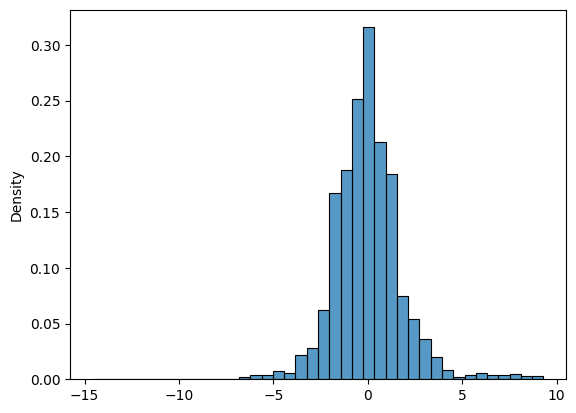

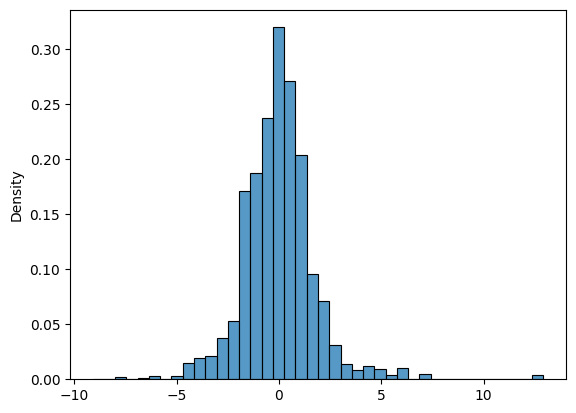

In [3]:
#################### inputs ####################
r = 0.85  # correlazione (panico)
nu = 3  # gradi di libertà per calm e panic driver t-student
j_bar = 1000  # numero di simulazioni Monte Carlo
c = 0.15  # threshold panico 
######################################################################

n_bar = len(stocks)  # numbero di asset
c_ret = diff(log(v), axis=1)  # redimenti capitalizzati
cr_c = corrcoef(c_ret)  # correlazione calm
rho2_panic = (1 - r)*eye(n_bar) + r*ones((n_bar, n_bar))  # correlazione panic

# computazione distribuzione panic tramite probabilità flessibili
z_calm = multivariate_t.rvs(zeros(n_bar), cr_c, nu, j_bar).T  # calm driver
z_panic = multivariate_t.rvs(zeros(n_bar), rho2_panic, nu, j_bar).T  # panic driver
b = where(z_panic < t.ppf(c, nu), 1, 0)  # panic trigger
z = (1 - b)*z_calm + b*z_panic  #  distributioni di scenari panic
p_bar = min_rel_entropy_sp(ones(j_bar)/j_bar, z_eq=z , mu_view_eq=zeros(n_bar))  # probabilità aggiustate per il downside risk

e_z = average(z, weights=p_bar, axis=1)  # medie attese 
print('e_z=', e_z)

################################ plots ################################
# distribuzioni panic 
scatterplot(x=z[0,:], y=z[1,:], hue=p_bar, palette='Greys_d'); show();

# prima distribuzione marginale
histplot(x=z[0,:], bins=40, weights=p_bar, stat='density'); show();

# seconda distribuzione marginale
histplot(x=z[1,:], bins=40, weights=p_bar, stat='density'); show();

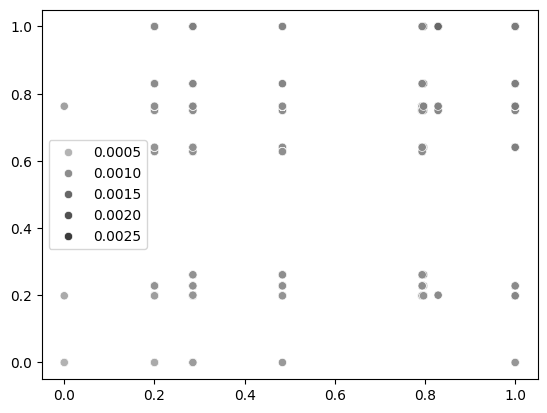

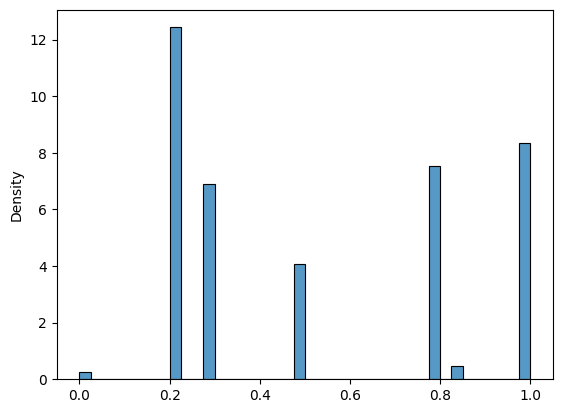

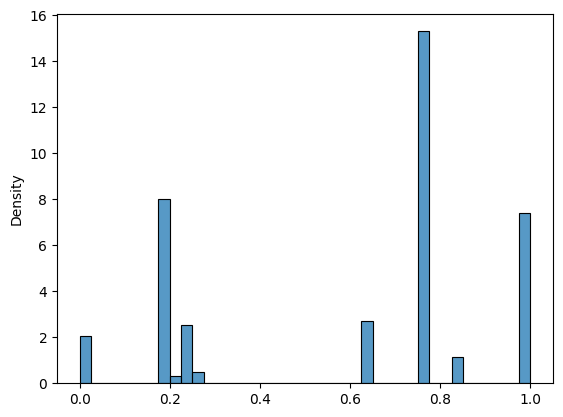

In [4]:
# processo separazione copula-marginal 
z_grid = sort(z, axis=1)
cdf_x = zeros((n_bar, j_bar))
for n in range(n_bar):
    # sorted panic distribution scenarios
    z_sort = Series(z[n, :]).iloc[argsort(z[n, :])]
    # sorted probabilities
    p_bar_sort = p_bar[argsort(z[n, :])]  
    # cumulative sums of sorted probabilities
    u_sort = append(0, cumsum(p_bar_sort))
    # indicies 
    index = [bisect_right(z_sort, z_grid[n, :][k]) for k in range(j_bar)]
    # marginal cdf's
    cdf_x[n, :] = squeeze(u_sort[index])  

# panic copula scenarios
index_sort = argsort(z, axis=1)
u = zeros((n_bar, j_bar))
for n in range(n_bar):
    u[n, index_sort[n, :]] = cdf_x[n, :]
# clear spurious outputs
u[u >= 1] = 1 - spacing(1)
u[u <= 0] = spacing(1)

################################# plots #################################
# panic copula
scatterplot(x=u[0, :], y=u[1, :], hue=p_bar, palette='Greys_d'); show();

# first marginal distribution
histplot(x=u[0, :], bins=40, weights=p_bar, stat='density'); show();

# second marginal distribution
histplot(x=u[1, :], bins=40, weights=p_bar, stat='density'); show();

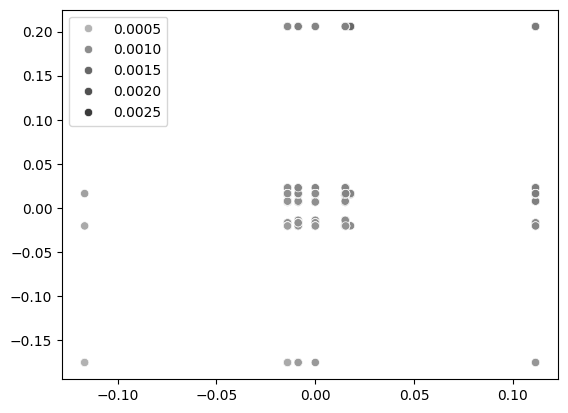

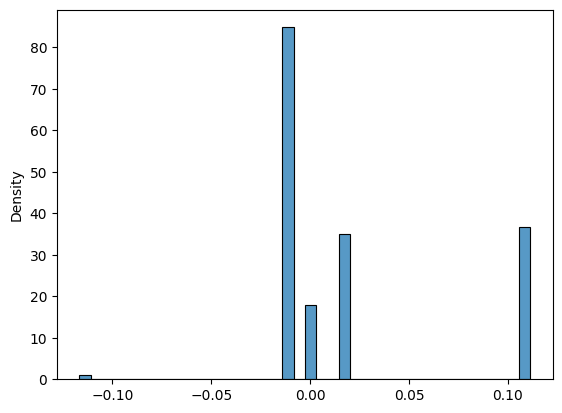

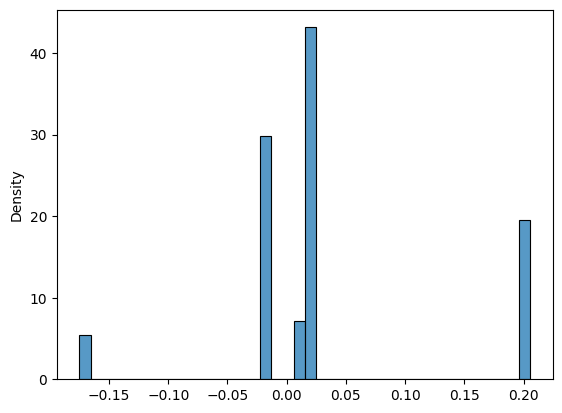

In [5]:
# combinazione panic copula e marginals storiche per ottenere distribuzioni joint market

####################### input #######################
tau_hl = 252*5  # half life for exponential decay probabilities (5 years)
#########################################################################

t_bar = c_ret.shape[1]  # length of compounded returns time series
# exponential time decay probabilities
p_exp_time_decay = exp(-(log(2)/tau_hl)*abs(t_bar - arange(0, t_bar)))
p_exp_time_decay = p_exp_time_decay/sum(p_exp_time_decay)  # rescaled probabilities

# marginal quantile function
c_ret_sort = sort(c_ret, axis=1)  # sorted scenarios
p_sort = p_exp_time_decay[argsort(c_ret, axis=1)]  # sorted probabilities
u_sort = insert(cumsum(p_sort), 0, 0)  # cumulative sums of sorted probabilities
# marginal quantiles evaluated at each copula scenario
y = zeros_like(u)
for n in range(n_bar):
    # find indices for quantiles using binary search
    q_index = searchsorted(u_sort, u[n, :], side='right') - 1
    q_index[q_index == -1] = 0
    q_index[q_index >= t_bar - 1] = t_bar - 2
    # joint market compounded return distribution
    y[n, :] = c_ret_sort[n, q_index]
    
################################# plots #################################
# market distribution
scatterplot(x=y[0, :], y=y[1, :], hue=p_bar, palette='Greys_d'); show();

# first marginal distribution
histplot(x=y[0, :], bins=40, weights=p_bar, stat='density'); show();

# second marginal distribution
histplot(x=y[1, :], bins=40, weights=p_bar, stat='density'); show();